Mount google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure that we have access to GPU.

In [2]:
!nvidia-smi

Sun Feb 11 13:17:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Check working directory

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [4]:
!ls

drive  sample_data


In [21]:
SOURCE_VIDEO_PATH = f"drive/MyDrive/dataset_1/Video_4Trim.mp4"

## Install YOLOv8


In [6]:
!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


## Install ByteTrack


In [7]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop

from IPython import display
display.clear_output()


import sys
sys.path.append(f"{HOME}/ByteTrack")


import yolox
print("yolox.__version__:", yolox.__version__)

yolox.__version__: 0.1.0


In [8]:
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

## Install Roboflow Supervision

In [9]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


import supervision
print("supervision.__version__:", supervision.__version__)

supervision.__version__: 0.1.0


In [10]:
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator

## Tracking utils

Manually match the bounding boxes coming from our model with those created by the tracker.

In [11]:
from typing import List

import numpy as np


# converts Detections into format that can be consumed by match_detections_with_tracks function
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

## Load pre-trained YOLOv8 model

In [12]:
!ls

assets	datasets  Dockerfile  LICENSE	 requirements.txt  setup.py  tutorials	yolox
build	deploy	  exps	      README.md  setup.cfg	   tools     videos	yolox.egg-info


In [13]:
!pip list

Package                          Version               Editable project location
-------------------------------- --------------------- -------------------------
absl-py                          1.4.0
aiohttp                          3.9.3
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall       

In [14]:
from ultralytics import YOLO

model = YOLO(os.path.relpath('/content/drive/MyDrive/Models/detection_with_141.pt'))
model.fuse()

Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs


In [22]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8x.pt source={SOURCE_VIDEO_PATH}

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8x summary (fused): 268 layers, 68200608 parameters, 0 gradients, 257.8 GFLOPs

WARNING ⚠️ NMS time limit 0.550s exceeded
video 1/1 (1/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 5 books, 108.0ms
video 1/1 (2/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 5 books, 65.5ms
video 1/1 (3/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 6 books, 58.4ms
video 1/1 (4/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 6 books, 50.1ms
video 1/1 (5/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 6 books, 50.2ms
video 1/1 (6/2465) /content/drive/MyDrive/dataset_1/Video_4Trim.mp4: 384x640 1 person, 1 laptop, 1 keyboard, 5 books, 37.6ms
video 1/1 (7/2465) /conte

## Predict and annotate single frame

In [34]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names
print(CLASS_NAMES_DICT)
# class_ids of interest
CLASS_ID = [0, 1, 2]

{0: 'main_box', 1: 'socket', 2: 'socket_with_box'}



0: 480x800 1 main_box, 1 socket, 16.6ms
Speed: 4.2ms preprocess, 16.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 800)


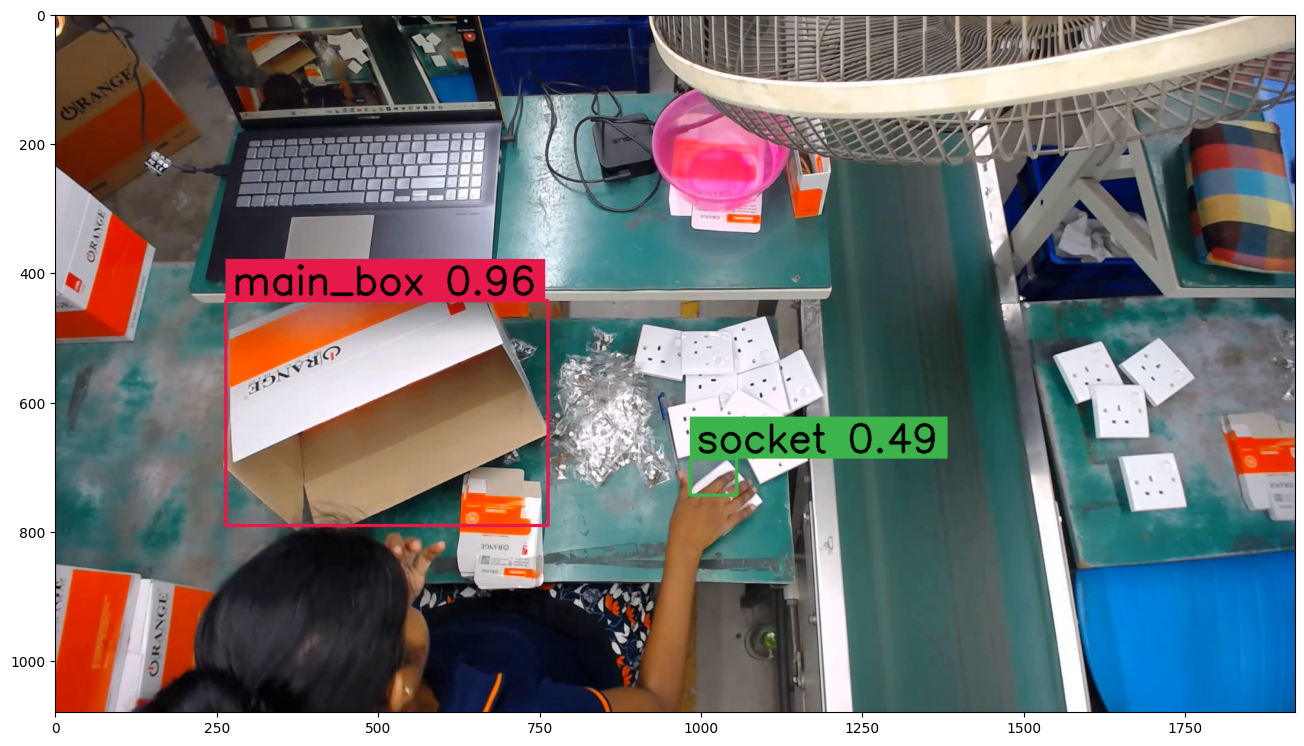

In [29]:
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (16, 16))

## Predict and annotate whole video

In [41]:
# settings
LINE_START = Point(950, 1000)
LINE_END = Point(950, 400)

TARGET_VIDEO_PATH = f"drive/MyDrive/Video_4_trim_count_1.mp4"

In [42]:
VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=1920, height=1080, fps=30, total_frames=2465)

In [43]:
from tqdm.notebook import tqdm

# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = get_video_frames_generator(SOURCE_VIDEO_PATH)
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

# open target video file
with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/2465 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
0: 480x800 1 main_box, 1 socket_with_box, 15.7ms
Speed: 4.4ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 17.1ms
Speed: 4.3ms preprocess, 17.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 15.7ms
Speed: 7.1ms preprocess, 15.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 15.6ms
Speed: 7.7ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 15.6ms
Speed: 6.2ms preprocess, 15.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 20.5ms
Speed: 5.4ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 800)

0: 480x800 1 main_box, 1 socket_with_box, 15.7ms
Speed: 7.4ms prepr